### 0. Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.get_logger().setLevel("ERROR")

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# ensure repo root is on path (notebook is assumed to be in repo_root/notebooks/)
ROOT = Path.cwd().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# src imports
from src.utils import read_csv, prc_data
from src.fis import get_CNN, fusion_alg
from src.metrics import get_all_err

### 1. Load data

In [2]:
# Select from participant_1 to participant_6
DATA_PATH = Path("../data/participant_1.csv")

# Load and pre-process data
data = read_csv(DATA_PATH)
t, SS, IMU, IMU_arm, IMU_tor, MCL, MCL_arm, MCL_tor, MCL_idx = prc_data(data)

# Get data during calibration 
rng = np.arange(MCL_idx[0][0], MCL_idx[0][1])
X, Y = SS[rng,:,:], IMU[rng,:]

### 2. Get SS-based estimates

In [3]:
# Train neural network
model = get_CNN(X, Y)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=Huber(delta=0.5))
model.fit(X, Y, epochs=100, batch_size=32, validation_split=0.2, verbose=0,
         callbacks=EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True))

# Get soft sensor only estimation
SS_est = model.predict(SS, verbose=0)

### 3. Apply FIS

In [4]:
# Fuse estimations from IMU and soft sensor
win = int(1/np.mean(np.diff(t)))*90 # 90 second-window for moving average filter
fusion_est = fusion_alg(IMU_arm, IMU_tor, SS_est, win)

### 4. Visualization

IMU Only
  RMSE for each trial: 3.9°, 19.3°, 23.5°, 20.7°, 10.9°, 
  Overall RMSE: 18.9°


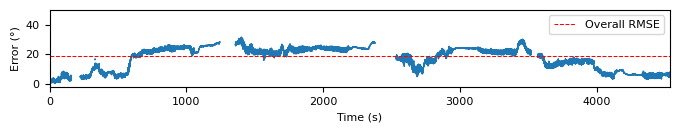

In [5]:
get_all_err(t, MCL, IMU, MCL_idx, "IMU Only"); # IMU only

SS Only
  RMSE for each trial: 13.0°, 14.4°, 13.8°, 15.9°, 16.3°, 
  Overall RMSE: 15.0°


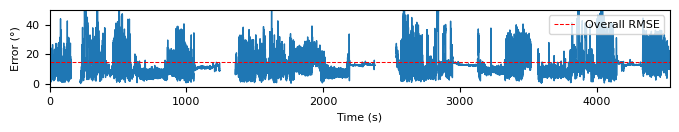

In [6]:
get_all_err(t, MCL, SS_est, MCL_idx, "SS Only"); # SS only

FIS (IMU + SS)
  RMSE for each trial: 4.3°, 4.2°, 3.2°, 4.0°, 4.1°, 
  Overall RMSE: 3.9°


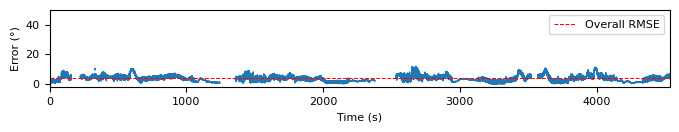

In [7]:
get_all_err(t, MCL, fusion_est, MCL_idx, "FIS (IMU + SS)"); # IMU+SS+LPF